In [4]:
from keras.applications.vgg16 import VGG16
model  = VGG16(weights='imagenet', include_top=False)
# model.summary()

In [5]:
# 모델의 각 층의 정보를 출력(이름)
for layer in model.layers:
  if 'conv' not in layer.name:
    continue
  filters,biases =  layer.get_weights()  # 필터의 가중치
  # print(layer.name, layer.output.shape)

In [6]:
input_img = model.input

from keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

layer_name = 'block1_conv1'  # 시각화 대상 필터 이름
filter_index = 0    # 필터가 64

# for layer in model.layers[1:]:  # 입력층을 제외한 모든 레이어
layer_dict = dict([ (layer.name, layer ) for layer in model.layers[1:]  ])

# 손실함수 : 대상 합성곱층의 n번째 필터의 활성화도가 최대가 된게 하는 손실함수
layer_output = layer_dict[layer_name].output
# layer_output, layer_output[:, :, :, filter_index], K.mean(layer_output[:, :, :, filter_index])
loss = K.mean(layer_output[:, :, :, filter_index])

# 입력 이미지에 대한 손실함수의 경사를 계산
grads = K.gradients(loss, input_img)[0]
grads /= (K.sqrt(K.mean(K.square(grads)))  +  1e-5)
iterate = K.function([input_img], [loss,grads]) # 입력이미지에대한 손실함수의 경사와  손실값을 리턴

In [13]:
# 경사상승법을 적용하는 함수
img_width = 128
img_height = 128
step = 1
import numpy as np
# 시작은 노이즈가 포함된 이미지로
input_img_data = np.random.random( (1,img_width,img_height,3) )*20+128
# 경사 상습법을 이용해서 20번 이미지를 수정
for i in range(100):
  loss_value,grads_value = iterate([input_img_data])
  input_img_data += grads_value*step

In [27]:
import copy
a = 10
b = a

a = 100
a,b

(100, 10)

In [15]:
# 텐서를 이미지로 변환해줄 함수 
# 텐서를 이미지로 변환해서 디스크에 저장
def deprocess_image(x):
  # 데이터 정규화
  # 평균이 0, 표준편차가 0.1이 되도록
  x -= x.mean()
  x /= (x.std()+1e-5)
  x *= 0.1

# 구간이 [0,1]로 클리핑
  x += 0.5
  x = np.clip(x,0,1)

# RGB 배열로 변환
  x *= 255
  # x = x.transpose((1,2,0))  
  x = np.clip(x,0,255).astype('uint8')
  return x
img = copy.deepcopy(input_img_data)
img = deprocess_image(img)

In [23]:
temp_a = np.array([1,2,3,4,5])
temp_b = copy.deepcopy(temp_a)

temp_b[0]=1000
temp_b,  temp_a

(array([1000,    2,    3,    4,    5]), array([1, 2, 3, 4, 5]))

In [16]:
# input_img_data.shape, input_img_data
img.shape

(1, 128, 128, 3)

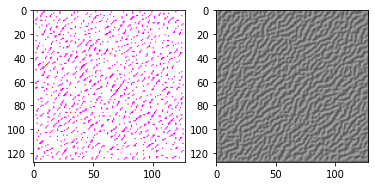

In [17]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(input_img_data.squeeze()) 
plt.subplot(1,2,2)
plt.imshow(img.squeeze()) 

In [28]:
# test code
from keras.layers.attention.multi_head_attention import activation
temp = tf.keras.models.Sequential([
 tf.keras.layers.Conv2D(64,(4,4),padding='valid',  activation='relu',input_shape = (28,28,1)),
 tf.keras.layers.MaxPool2D(2,2),
 tf.keras.layers.Conv2D(128,(3,3), padding='valid',activation='relu'),
 tf.keras.layers.MaxPool2D(2,2)
])

In [32]:
####################### 
from __future__ import print_function
from tensorflow.keras.preprocessing.image import load_img , img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from keras import backend as K

import time
import argparse

In [33]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

model.summary()

Model loaded.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None,

In [37]:
input_img = model.input
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)
layer_name = 'block5_conv1'
img_width = 128
img_height = 128
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # if K.common.image_dim_ordering() == 'th':
    #     x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x    

In [38]:
kept_filters = []

for filter_index in range(0, 10):    
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    layer_output = layer_dict[layer_name].output
    
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, input_img)[0]

    grads = normalize(grads)

    iterate = K.function([input_img], [loss, grads])

    step = 1.

    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            break

    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Current loss value: 12.322491
Current loss value: 26.556328
Current loss value: 49.162964
Current loss value: 69.51262
Current loss value: 89.28647
Current loss value: 110.12117
Current loss value: 135.76949
Current loss value: 155.71545
Current loss value: 183.12558
Current loss value: 202.40704
Current loss value: 231.28357
Current loss value: 250.6698
Current loss value: 273.01752
Current loss value: 294.34314
Current loss value: 315.96634
Current loss value: 342.35696
Current loss value: 367.1542
Current loss value: 394.05707
Current loss value: 417.0908
Current loss value: 440.06305
Filter 0 processed in 11s
Processing filter 1
Current loss value: 0.016978895
Current loss value: 8.871458
Current loss value: 36.91442
Current loss value: 59.974297
Current loss value: 83.38928
Current loss value: 115.903564
Current loss value: 144.72174
Current loss value: 185.5392
Current loss value: 229.21504
Current loss value: 276.47235
Current loss value: 323.76712
Current lo